# Model Performance Evaluation
In this notebook we seek to evaluate the performance of different models using a range of different metrics. The most basic of which are Punzi scans, predicted probability distributions, Kolmogrov-Smirnov tests and ROC curves.

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import sys
sys.path.append('../')
from dataflow import Flow
import plotter as ptr
import xgboost as xgb
from sklearn.metrics import roc_curve

In [7]:
version = "6.0.4"
fname = f'../data_files/{version}'
my_flow = Flow(None, None, None, csv_path=f'{fname}.csv')
(X_train, y_train), (X_val, y_val), (X_test, y_test) = my_flow.get_train_val_test_split()

train = X_train.copy()
train['category'] = y_train

val = X_val.copy()
val['category'] = y_val

test = X_test.copy()
test['category'] = y_test

In [8]:
from joblib import load

my_nn_model = tf.keras.models.load_model(f'../neural_network/models/v{version}')
my_xgb_model = xgb.XGBClassifier()
my_xgb_model.load_model(f"../classification_methods/models/XGB_{version}.json")
my_knn_model = load('../classification_methods/models/KNN_6.0.3.joblib')
my_models = [my_xgb_model, my_nn_model, my_knn_model]
my_model_names = ['XGB', 'NN', 'KNN']

2022-03-08 19:09:50.668902: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 19:09:50.675379: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
# Define some pretty colours to use
colors = {
            "<class 'tensorflow.python.keras.engine.sequential.Sequential'>": 
                {'train': '#3366ff', 'val': '#66cc00', 'test': 'red'},
            "<class 'xgboost.sklearn.XGBClassifier'>":
                {'train': '#0000ff', 'val': '#33cc00', 'test': 'green'},
            "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>":
                {'train': '#6666ff', 'val': '#339900', 'test': 'blue'},
            "<class 'sklearn.ensemble._forest.RandomForestClassifier'>":
                {'train': '#99ccff', 'val': '#66cc99', 'test': 'orange'}
            }

## Predicted Probability Distributions

In [10]:
myPlot = ptr.ProbabilityDistribution(train, val, test)

2022-03-08 19:09:52.970251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-08 19:09:53.003739: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


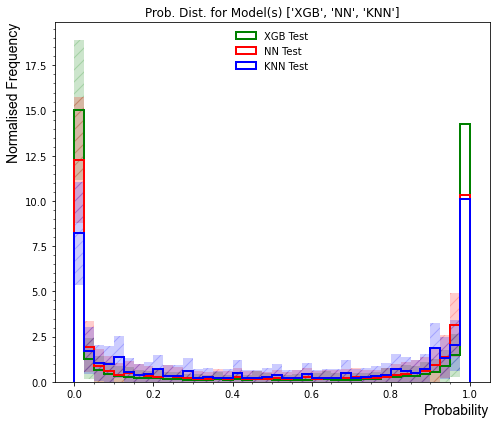

In [11]:
myPlot.plot_singular(my_models, my_model_names, "test", hide_errors=False, colors=colors)

The XGB model had the best signal and background discrimination from naively looking at this plot. The XGB model had the highest frequencies in the lowest and highest bins marking a high-level of polarisation. That is - it is very certain about the predictions most of the time assigning either a very low or very high probability. A similar satement can be made for the NN. However, the KNN model struggles to classify background (and signal). The peaks are less established at the extremes of probability and are elevated in the middling region. The KNN looks to be too simpler of a model and is unable to learn enough from these data to really finely categorise events.

## ROC Curves

In [12]:
xgb_probs = my_xgb_model.predict_proba(test.drop('category', axis=1))[:,1]
knn_probs = my_knn_model.predict_proba(test.drop('category', axis=1))[:,1]
nn_probs = np.squeeze(my_nn_model.predict(test.drop('category', axis=1)))

xgb_probs2 = my_xgb_model.predict_proba(train.drop('category', axis=1))[:,1]
knn_probs2 = my_knn_model.predict_proba(train.drop('category', axis=1))[:,1]
nn_probs2 = np.squeeze(my_nn_model.predict(train.drop('category', axis=1)))

all_test_prob_preds = [xgb_probs, nn_probs, knn_probs]
all_train_prob_preds = [xgb_probs2, nn_probs2, knn_probs2]

In [13]:
roc_test_data = {}
roc_train_data = {}

for i, m in enumerate(all_test_prob_preds):
    roc_test_data[my_model_names[i]] = roc_curve(test['category'], m)
    roc_train_data[my_model_names[i]] = roc_curve(train['category'], all_train_prob_preds[i])

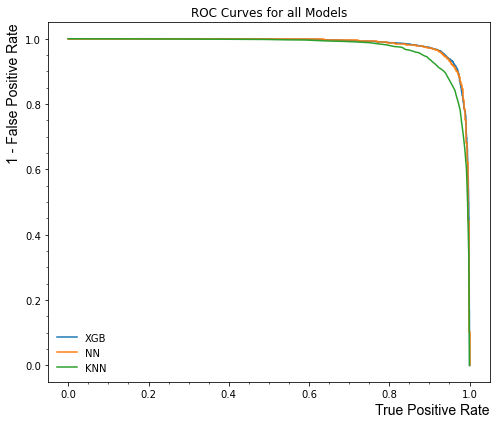

In [14]:
fonts = {'fontname': 'Arial'}

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
fig.patch.set_facecolor('#FFFFFF')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
for key, value in roc_test_data.items():
    ax.plot(1-value[0], value[1], label=key)
plt.ylabel('1 - False Positive Rate', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel('True Positive Rate', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.title(f'ROC Curves for all Models')
plt.legend(loc='lower left', ncol=1, fancybox=False, shadow=True, frameon=False)
plt.tight_layout()
plt.show()

Models perform all exceedingly well. If there is any overfitting it is very minimal and not influencing these models ability to generalise to unseen test data. We should also plot the ROC curves for each model in the test versus the train instance and look for any discrepancies (this would indicate overtraining).

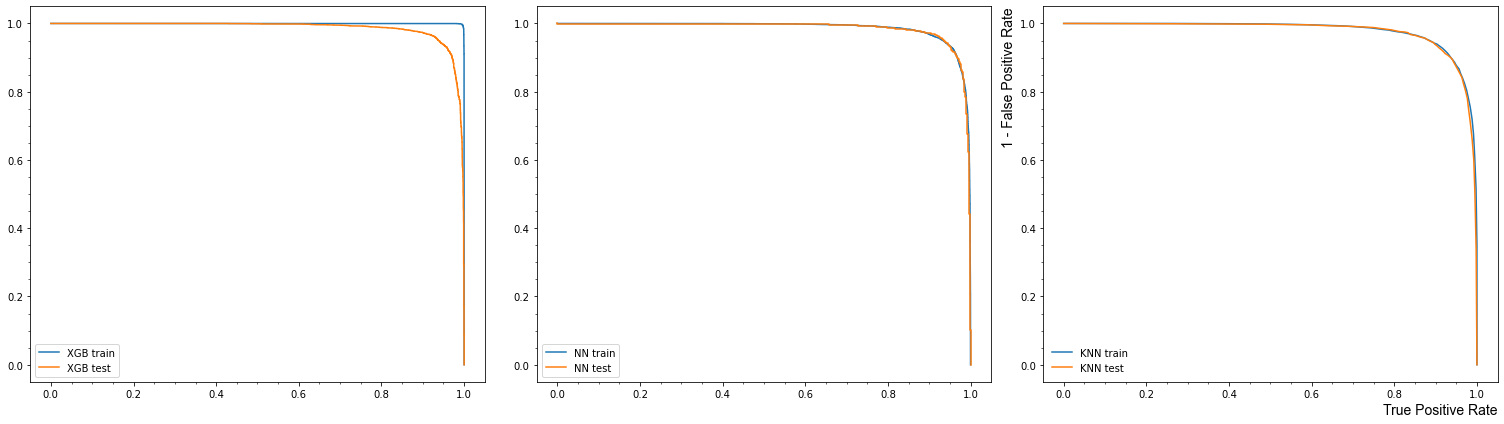

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(21, 6))
fig.patch.set_facecolor('#FFFFFF')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())

i = 0
for key, value in roc_train_data.items():
    ax[i].plot(1-value[0], value[1], label=f'{key} train')
    ax[i].plot(1-roc_test_data[key][0], roc_test_data[key][1], label=f'{key} test')
    i += 1

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.ylabel('1 - False Positive Rate', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel('True Positive Rate', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.legend(loc='lower left', ncol=1, fancybox=False, shadow=True, frameon=False)
plt.tight_layout()
plt.show()

Well the XGB model is very overtrained. The others are not at all overtrained...maybe we need to a find a better XGB model!

## Kolmogorov-Smirnov Goodness-of-Fit Test
How similar are two underlying distributions? We test this with the KS-test. We want the predicted probability distributions for the train, validation and test data to be very similar. If this is the case then there is no evidence of overfitting.

In [16]:
from scipy.stats import ks_2samp

In [17]:
# XGB Model
ks1, p1 = ks_2samp(all_test_prob_preds[0], all_train_prob_preds[0])

# Neural Network Model
ks2, p2 = ks_2samp(all_test_prob_preds[1], all_train_prob_preds[1])

# KNN Model
ks3, p3 = ks_2samp(all_test_prob_preds[2], all_train_prob_preds[2])

In [18]:
print(f"XGB Model\nKS: {ks1:.4f}\nP-Value: {p1:.6f}\n")
print(f"NN Model\nKS: {ks2:.4f}\nP-Value: {p2:.6f}\n")
print(f"KNN Model\nKS: {ks3:.4f}\nP-Value: {p3:.6f}\n")

XGB Model
KS: 0.0321
P-Value: 0.000026

NN Model
KS: 0.0094
P-Value: 0.710713

KNN Model
KS: 0.0081
P-Value: 0.860418



Again similar analysis shows there is no large overfitting in either dataset with respect to the predicted probability distributions. This is because the very small KS statistic value implies the null hypothesis (F(x)=G(x)) cannot be rejected.

## Punzi Scan

In [64]:
def calculate_punzi(preds, labelled_data, prob_range=[0.3, 0.98], dpoints=150, significance=5, mass_range=[5200, 5800]):    
    probability_space = np.linspace(prob_range[0], prob_range[1], dpoints)
    # A region over which the Punzi FOM will be calculated
    
    labels = labelled_data['category'].to_numpy()
    nsignal_before = labelled_data['category'].value_counts()[1]
    # How many signal events are in the original data sample
    
    punzis = []
    for p in probability_space:
        # Iterate through each point in probability space
        
        # Each event is predicted a probability P. If P < p we say that,
        # it is background, else it is signal. I.e. p -> 1 in limit of high
        # background rejection, high purity sample 
        
        ps = np.squeeze(np.where(preds < p, 0, 1))
        all = np.array([ps, labels]).T
        
        efficiency = len(np.squeeze(np.where((all == [1, 1]).all(axis=1)))) / nsignal_before
        # Truth matched signal i.e. model said it was signal and it actually was 
        background = np.squeeze(np.where((all == [1, 0]).all(axis=1)))
        try:
            background = background.shape[0]
        except:
            background = 0
        # background you thought was signal, so did not reject i.e. it got through 
        
        #print(f'{p:.4f} {efficiency:.5f} {background}')
        # Background is how much background is left after the cut i.e. how much REAL background is left (incorrectly identified as signal)
        
        punzi = efficiency / (significance/2 + np.sqrt(background))
        # Calculate the Punzi as defined by LHCb 
        
        punzis.append(punzi)
        # Add this point to the array of Punzis
    return np.array(punzis), probability_space

In [65]:
xgb_punzi_values, xgb_pspace = calculate_punzi(all_test_prob_preds[0], test, dpoints=300)
nn_punzi_values, nn_pspace = calculate_punzi(all_test_prob_preds[1], test, dpoints=300)
knn_punzi_values, knn_pspace = calculate_punzi(all_test_prob_preds[2], test, dpoints=300)

xgb_punzi_values1, xgb_pspace1 = calculate_punzi(all_train_prob_preds[0], train, dpoints=300)
nn_punzi_values1, nn_pspace1 = calculate_punzi(all_train_prob_preds[1], train, dpoints=300)
knn_punzi_values1, knn_pspace1 = calculate_punzi(all_train_prob_preds[2], train, dpoints=300)

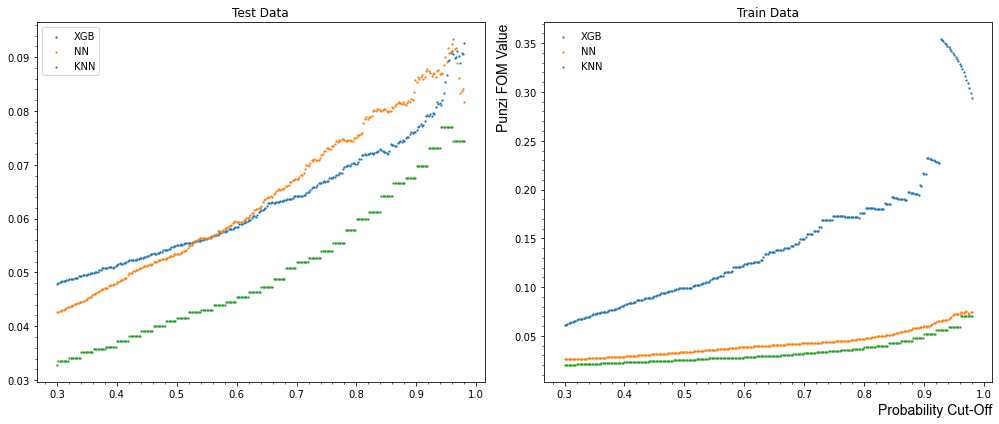

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('#FFFFFF')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].scatter(xgb_pspace, xgb_punzi_values, label='XGB', s=1.5)
ax[0].scatter(nn_pspace, nn_punzi_values, label='NN', s=1.5)
ax[0].scatter(knn_pspace, knn_punzi_values, label='KNN', s=1.5)
ax[0].set_title('Test Data')

ax[1].scatter(xgb_pspace1, xgb_punzi_values1, label='XGB', s=1.5)
ax[1].scatter(nn_pspace1, nn_punzi_values1, label='NN', s=1.5)
ax[1].scatter(knn_pspace1, knn_punzi_values1, label='KNN', s=1.5)
ax[1].set_title('Train Data')

ax[0].legend()
ax[1].legend()

plt.ylabel('Punzi FOM Value', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel('Probability Cut-Off', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.legend(loc='upper left', ncol=1, fancybox=False, shadow=True, frameon=False)
plt.tight_layout()
plt.show()

From the look of these Punzi plots we are safe to take a cut position of about 0.85. This should provide excellent purity of signal and reduction of background with the drawback of some signal being potentially lost.

## Binary Accuracy Evaluation

## SHAP Values

In [ ]:
import shap